# TITLE: MARKET BASKET ANALYSIS OF INSTACART DATASET WITHOUT USING MLXTEND

## Introduction to Instacart and Market Basket Analysis

### INSTACART

Instacart is a grocery delivery company in the United States and Canada. It's service allows customers to order groceries from participaing retailers via a website and mobile app. The orders are shopped and delivered by an Instacart personal shopper. Instacart was founded in 2012 by Apoorva Mehta, Max Mullen and Brandon Leonardo with its headquarter at San Francisco, California. At present, Instacart operates in thousands of cities across the United States and Canada and serving millions of customers everyday.

### Market Basket Analysis

Market basket analysis is one of the effective data processing technique used by merchants to understand and analyse their customer's shopping behaviour. 

It helps
* to find customer purchase patterns
* to identify associations between products that are frequently bought together
* to recommend products to customers
* to deploy cross selling strategies
* to optimize the inventory according to customers behaviour
* to improve retailer's profitability, service quality and customer satisfaction

### Objectives

* To analyze the data
* To find out hidden association between products for better cross-selling

## Importing Python Libraries and Instacart Dataset

### Required Python Libraries

In [45]:
# Importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from collections import Counter
import networkx as nx

### Importing the Instacart Dataset

Instacart dataset was gathered from Kaggle. It is an open source public dataset released by Instacart in 2017. The dataset is anonymized and contains a sample of over 3 million grocery orders from more than 200,000 Instacart users. The dataset can be downloaded from https://www.kaggle.com/competitions/instacart-market-basket-analysis/data and can be utilised only for non-commercial purposes.

The downloaded dataset contains following .csv files.
* aisles.csv
* departments.csv
* order_products__prior.csv
* order_products__train.csv
* orders.csv
* products.csv
* sample_submission.csv
  
sample_submission.csv file doesnot contain any useful data. It is primarily a part of Instacart dataset which can be used for testing purpose in the context of machine learning applications. So, sample_submission.csv file is omitted in this analysis.  

In [3]:
# All required .csv files are imported using pandas library into the respective variables
aisles = pd.read_csv("aisles.csv")
dptms = pd.read_csv("departments.csv")
ordpp = pd.read_csv("order_products__prior.csv")
ordpt = pd.read_csv("order_products__train.csv")
orders = pd.read_csv("orders.csv")
products = pd.read_csv("products.csv")

# Listing out all file variables in a list named "files"
# Also Listing out all file variable names also in a list named "file_names"
# While analysing the data, the same order of files are utilised
files = [aisles,dptms,ordpp,ordpt,orders,products]
file_names = ["aisles","departments","order_products__prior",
              "order_products__train","orders","products"]

## Basic Desription of Data

### The following code helps
* to get top 5 head rows to visualise the data
* to count the total number of rows and columns in respective file
* to find the columns datatypes
* to find the columns with null_values
* to count the number of unique values in each column
* to check if there are any duplicated rows or not

In [4]:
# Initialise variable k which represents index of the lists named "files" and "file_names"
k = 0

for i in files:
    # printing the file name
    print(f"FILE NAME = {file_names[k].upper()}")
    
    # printing the top 5 head rows
    print(i.head().to_string(index=False))
    
    # printing the file info
    print()
    print(i.info())
    
    # finding the variables with null values
    print()
    if any(i.isnull().sum()) != 0:
        n = len(i.columns)
        for j in range(n):
            if i[str(i.columns[j])].isnull().sum() != 0:
                print(f"{i.columns[j]} has {i[str(i.columns[j])].isnull().sum()} null values")
    else:
        print(f"No Variables with Null values in {file_names[k]} file")
    
    # finding the number of duplicated rows
    print(f"Duplicated rows in {file_names[k]}: {i.duplicated().sum()}")

    # finding the number of unique values in each column of the files
    print()
    print(f"Number of unique values in {file_names[k]} file")
    for j in i.columns:
        print(f"{j}: {i[j].nunique()}")
    
    k+=1
    print("-"*100)

FILE NAME = AISLES
 aisle_id                      aisle
        1      prepared soups salads
        2          specialty cheeses
        3        energy granola bars
        4              instant foods
        5 marinades meat preparation

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   aisle_id  134 non-null    int64 
 1   aisle     134 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.2+ KB
None

No Variables with Null values in aisles file
Duplicated rows in aisles: 0

Number of unique values in aisles file
aisle_id: 134
aisle: 134
----------------------------------------------------------------------------------------------------
FILE NAME = DEPARTMENTS
 department_id department
             1     frozen
             2      other
             3     bakery
             4    produce
             5    alcohol

<class 'pandas.core.frame

### Summary about each column of the files

aisles (134 rows):
* aisle_id: aisle identifier
* aisle: the name of the aisle

deptartments (21 rows):
* department_id: department identifier
* department: the name of the department
  
order_products__prior (32434489 rows):
* order_id: foreign key
* product_id: foreign key
* add_to_cart_order: order in which each product was added to cart
* reordered: 1 if this product has been ordered by this user in the past, 0 otherwise

order_products__train (1384617 rows):
* order_id: foreign key
* product_id: foreign key
* add_to_cart_order: order in which each product was added to cart
* reordered: 1 if this product has been ordered by this user in the past, 0 otherwise

orders (3421083 rows, 206209 users):
* order_id: order identifier
* user_id: customer identifier
* eval_set: which evaluation set this order belongs in (see SET described below)
* order_number: the order sequence number for this user (1 = first, n = nth)
* order_dow: the day of the week the order was placed on
* order_hour_of_day: the hour of the day the order was placed on
* days_since_prior: days since the last order, capped at 30 (with NAs for order_number = 1)

products (49688 rows):
* product_id: product identifier
* product_name: name of the product
* aisle_id: foreign key
* department_id: foreign key

where SET is one of the four following evaluation sets (eval_set in orders):
* "prior": orders prior to that users most recent order (~3.2m orders)
* "train": training data supplied to participants (~131k orders)
* "test": test data reserved for machine learning competitions (~75k orders)

## Exploratory Data Analysis on orders.csv

### Visualising the value counts of columns in orders (which have nunique <= 31) using count plot

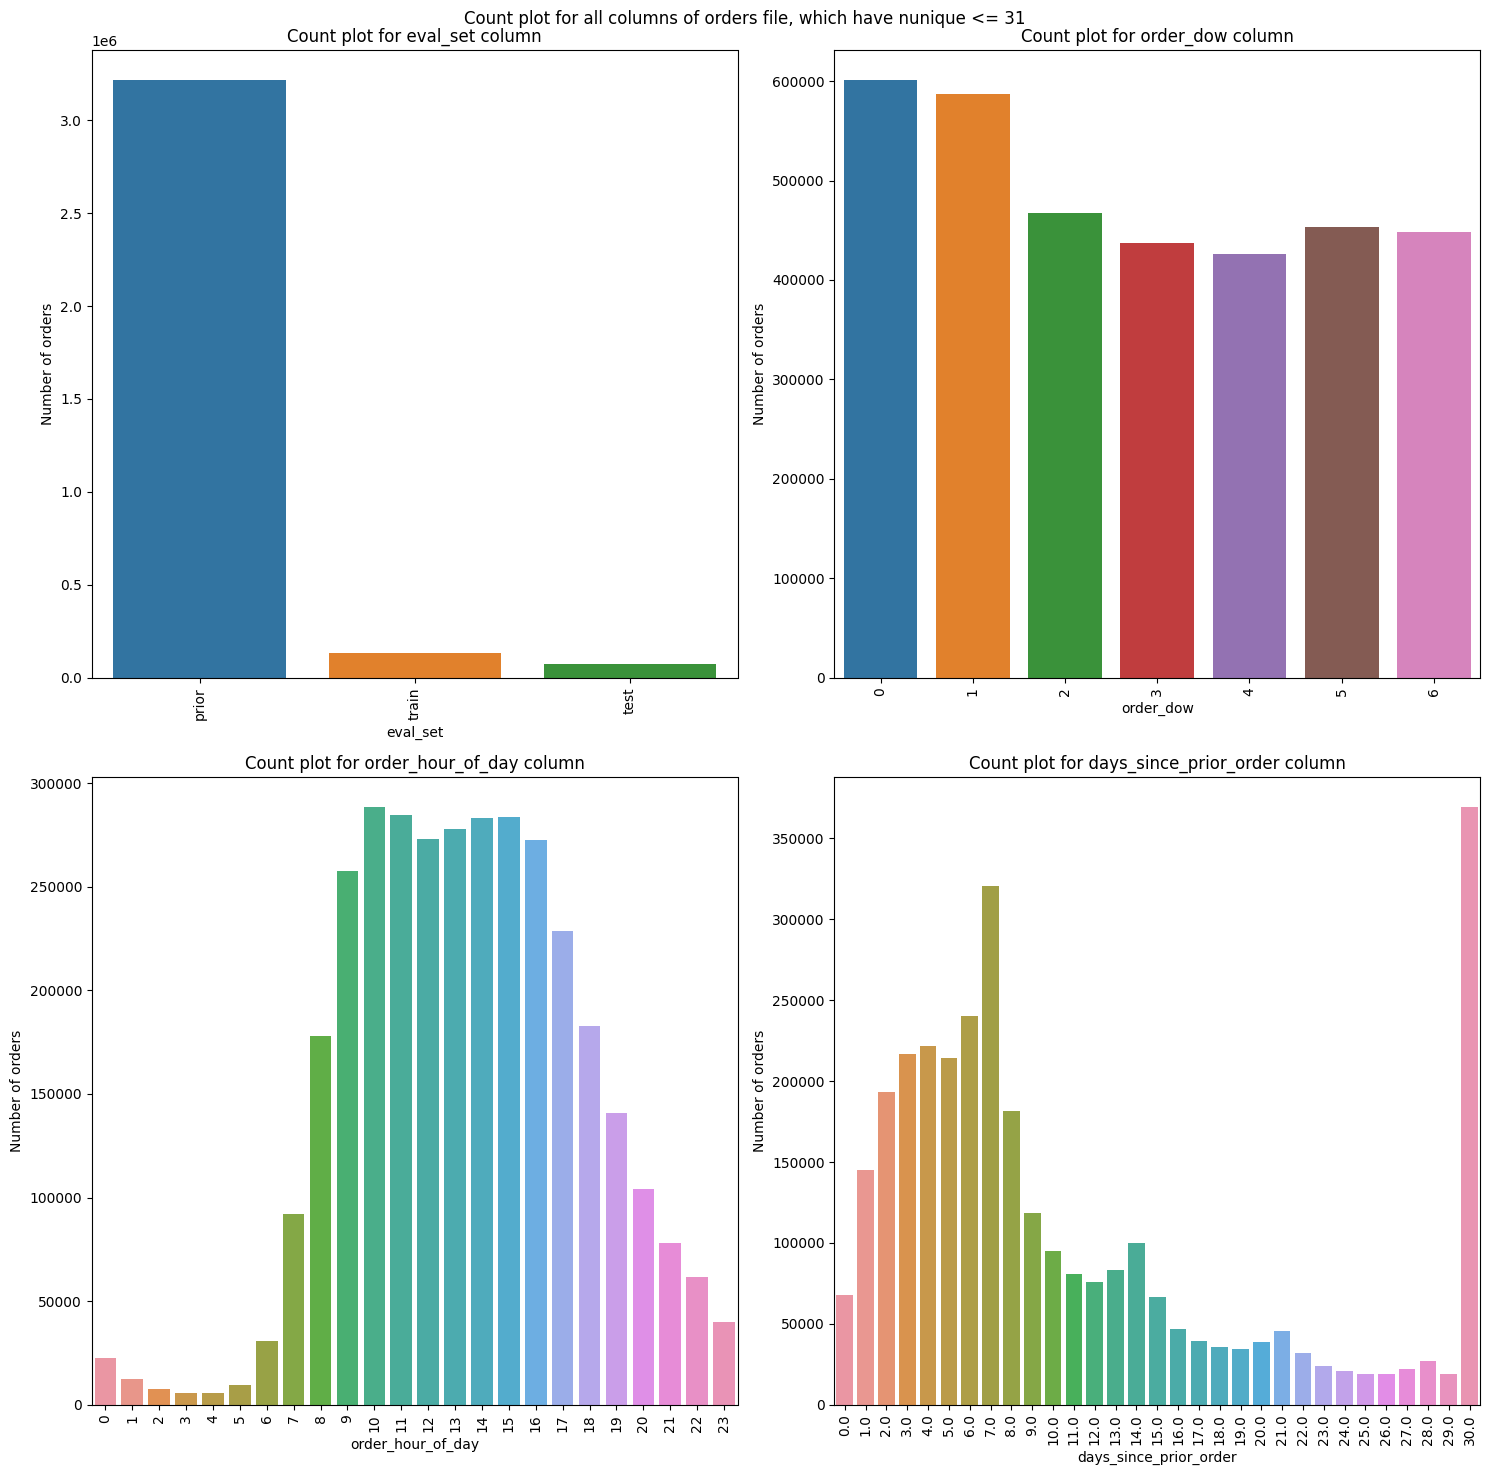

In [5]:
fig = plt.figure(figsize = (15,15))
fig.suptitle("Count plot for all columns of orders file, which have nunique <= 31")
k = 1
for i in orders.columns:
    if orders[i].nunique() <= 31:
        plt.subplot(2,2,k)
        plt.title(f"Count plot for {i} column")
        sns.countplot(data = orders, x = i)
        plt.ylabel("Number of orders")
        plt.xticks(rotation = 90)
        k += 1
plt.tight_layout()
plt.show()

Observations:
* day_of_the_week = 0 and day_of_the_week = 1 represents Saturday and Sunday as number of orders on weekends will be generally higher than other days of the week.
* Peak hours of the day are from 9 AM to 5 PM
* Significant jumps in number of orders can be observed for Weekly(7 days), Bi-weekly (14 days) and Monthly (30 days). Thus Customers have tendency to visit the Instacart weekly, bi-weekly and monthly time gaps.
* According the data description from kaggle, All the orders with days_since_prior_order > 30 days are bounded to 30 days. So 30 days has highest peak in the graph

### Descriptive Statistics of orders["days_since_prior_order"] file

In [6]:
print(orders["days_since_prior_order"].describe().apply(lambda x: "%0.2f"%x))

count    3214874.00
mean          11.11
std            9.21
min            0.00
25%            4.00
50%            7.00
75%           15.00
max           30.00
Name: days_since_prior_order, dtype: object


Observations:
* On average, Customer reorders every 11 days.
* According to median, 50% of customers reorders every 7 days
* According to 75th percentile, 75% of customers reorders every 15 days
* So only 25% customers reorders with gap greater than 15 days.

### Analysing the orders.csv with user level granularity

#### Finding the maximum orders done by each user_id, Bar plot between Number of users Vs Max Order Number and other related descriptive statistics

In [7]:
order_number_max = orders.groupby("user_id")["order_number"].max()
order_number_max_count = order_number_max.value_counts()

Text(0.5, 1.0, ' Number of users Vs Max Order Number')

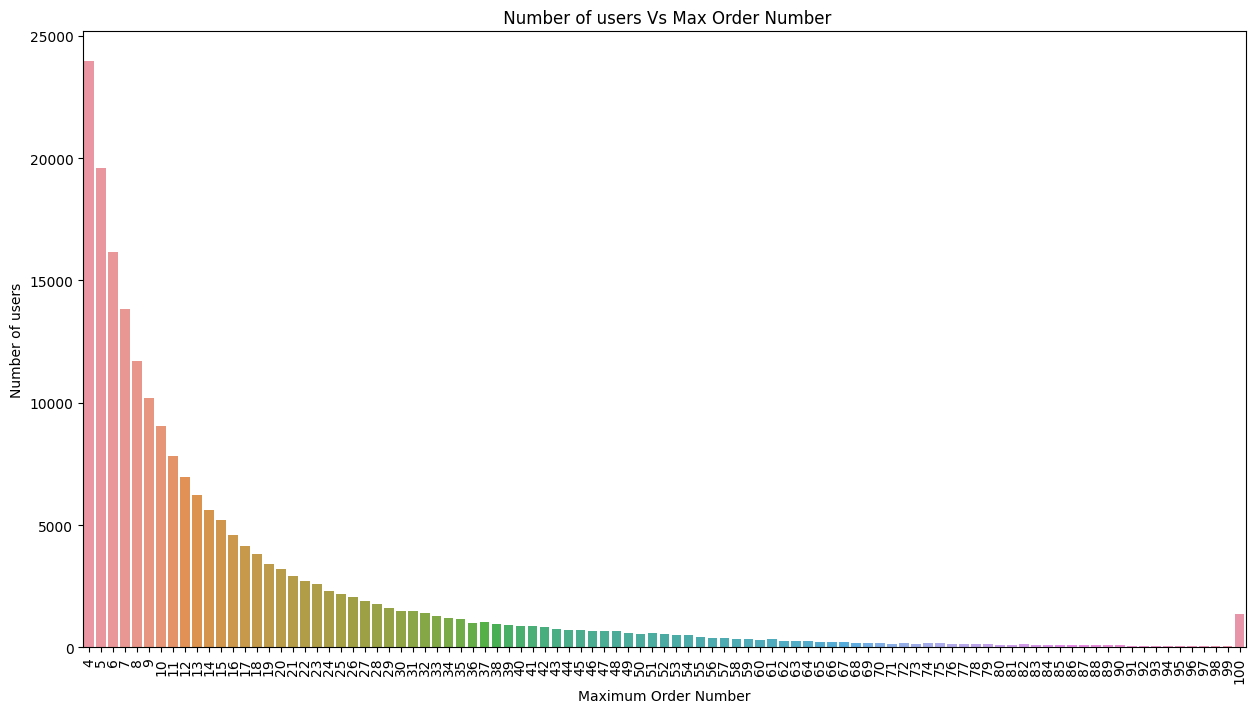

In [8]:
fig = plt.figure(figsize=(15,8))
sns.barplot(x = order_number_max_count.index, y = order_number_max_count.values)
plt.xlabel('Maximum Order Number')
plt.ylabel('Number of users')
plt.xticks(rotation = 90)
plt.title(' Number of users Vs Max Order Number')

In [9]:
order_number_max.describe().apply(lambda x: "%0.2f"%x)

count    206209.00
mean         16.59
std          16.65
min           4.00
25%           6.00
50%          10.00
75%          20.00
max         100.00
Name: order_number, dtype: object

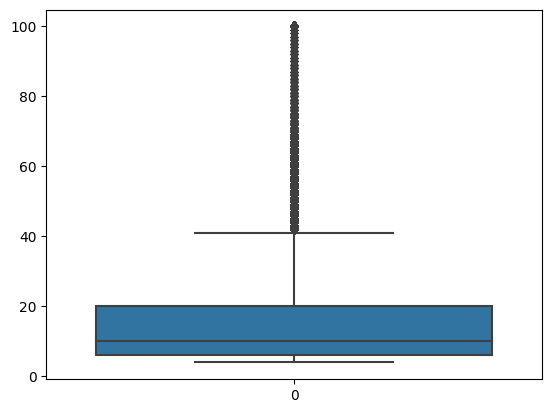

In [10]:
ax = sns.boxplot(data = order_number_max.values)

In [11]:
order_number_max.quantile(0.75)

20.0

In [12]:
# Finding the upper whisker
IQR = order_number_max.quantile(0.75) - order_number_max.quantile(0.25)
upper_whisker = order_number_max.quantile(0.75) + (1.5 * (IQR))
print(upper_whisker)

41.0


Observations:
* According to mean, Users has kept 16 orders.
* According to median, 50% of Users has kept 10 orders.
* According to 75% percentile, 75% of users has kept 20 orders.
* Maximum orders done by user bounded to 100.
* Box plot and IQR suggests that upper whisker of order_number_max = 41 and all the users who has done orders more than 41 are outliers

#### Number of users vs (Day of week, order hour of day, days since prior order)

In [13]:
orders.columns

Index(['order_id', 'user_id', 'eval_set', 'order_number', 'order_dow',
       'order_hour_of_day', 'days_since_prior_order'],
      dtype='object')

In [14]:
orders.groupby('order_number')["user_id"].nunique()

order_number
1      206209
2      206209
3      206209
4      206209
5      182223
        ...  
96       1592
97       1525
98       1471
99       1421
100      1374
Name: user_id, Length: 100, dtype: int64

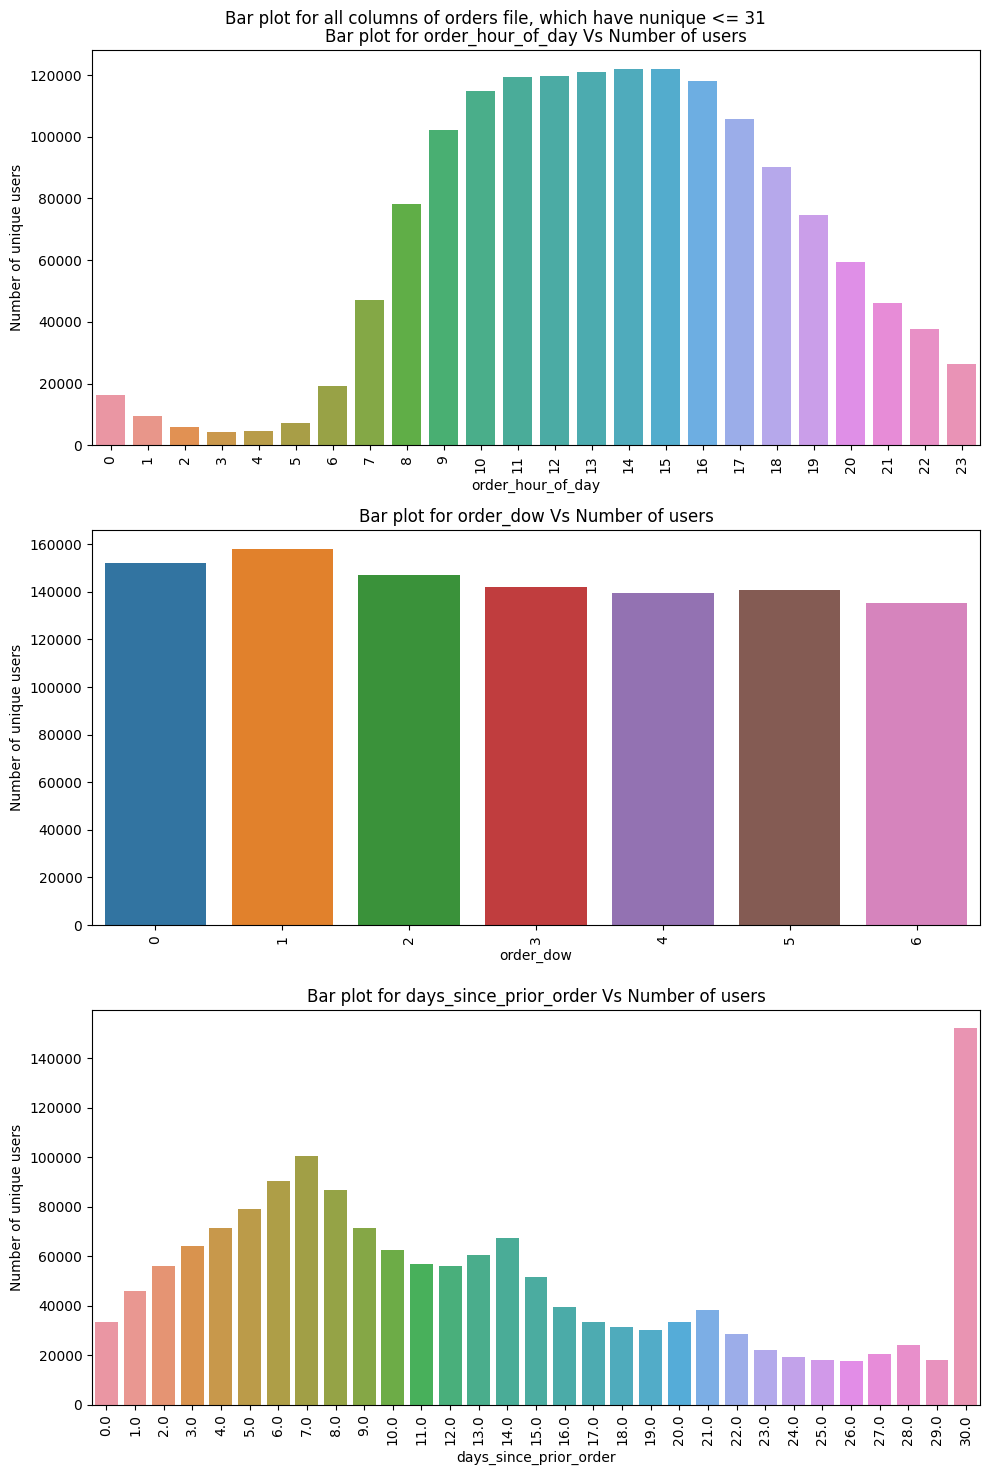

In [15]:
fig = plt.figure(figsize = (10,15))
fig.suptitle("Bar plot for all columns of orders file, which have nunique <= 31")
k = 1
for i in ["order_hour_of_day","order_dow","days_since_prior_order"]:
        plt.subplot(3,1,k)
        plt.title(f"Bar plot for {i} Vs Number of users")
        data = orders.groupby(i)["user_id"].nunique()
        sns.barplot(x = data.index, y = data.values)
        plt.ylabel("Number of unique users")
        plt.xticks(rotation = 90)
        k += 1
plt.tight_layout()
plt.show()

Observations:
On comparison with order level granularity graphs and user level granularity graphs
* On Saturday, There more number of orders but less number of users compared to sunday
* order_hour_of_day and days_since_prior_order trends are similar

### Heat map between Day_of_Week and Hour_of_day

In [16]:
temp_df = orders.groupby(["order_dow", "order_hour_of_day"])["order_number"].aggregate("count").reset_index()
temp_df = temp_df.pivot('order_dow', 'order_hour_of_day', 'order_number')
temp_df.head()

C:\Users\saina\AppData\Local\Temp\ipykernel_24500\2896508160.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  temp_df = temp_df.pivot('order_dow', 'order_hour_of_day', 'order_number')


order_hour_of_day,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
order_dow,,,,,,,,,,,,,,,,,,,,,
0,3936,2398,1409,963,813,1168,3329,12410,28108,40798,...,54552,53954,49463,39753,29572,22654,18277,14423,11246,6887
1,3674,1830,1105,748,809,1607,5370,16571,34116,51908,...,46764,46403,44761,36792,28977,22145,16281,11943,8992,5620
2,3059,1572,943,719,744,1399,4758,13245,24635,36314,...,37173,37469,37541,32151,26470,20084,15039,10653,8146,5358
3,2952,1495,953,654,719,1355,4562,12396,22553,32312,...,34773,35990,35273,30368,25001,19249,13795,10278,8242,5181
4,2642,1512,899,686,730,1330,4401,12493,21814,31409,...,33625,34222,34093,29378,24425,19350,14186,10796,8812,5645


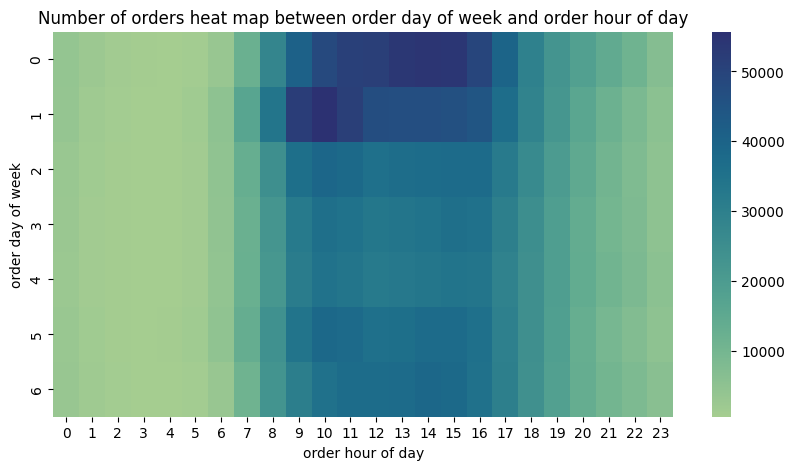

In [17]:
data = orders.groupby(["order_dow","order_hour_of_day"])["order_id"].agg("count").reset_index()
data = data.pivot(index = "order_dow",columns = "order_hour_of_day",values = "order_id")
fig = plt.figure(figsize=(10,5))
sns.heatmap(data = data,cmap = "crest")
plt.title("Number of orders heat map between order day of week and order hour of day")
plt.xlabel("order hour of day")
plt.ylabel("order day of week")
plt.show()

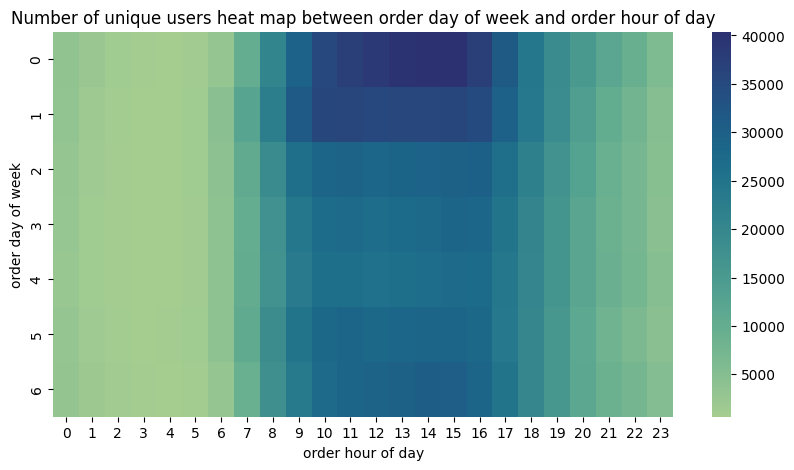

In [18]:
data = orders.groupby(["order_dow","order_hour_of_day"])["user_id"].nunique().reset_index()
data = data.pivot(index = "order_dow",columns = "order_hour_of_day",values = "user_id")
fig = plt.figure(figsize=(10,5))
sns.heatmap(data = data,cmap = "crest")
plt.title("Number of unique users heat map between order day of week and order hour of day")
plt.xlabel("order hour of day")
plt.ylabel("order day of week")
plt.show()

Observations:
* Saturday afternoon and Sunday morning are peak hours according to number of orders as well as number of users

## Exploratory Data Analysis on order_products_prior and train stacked file

### Vertically stacking the order_products_prior and train

In [19]:
# Vertically Stacking the order_products__prior and order_products__train 
stacked_ordp = pd.concat([ordpp,ordpt],axis = 0)

In [20]:
stacked_ordp.shape

(33819106, 4)

In [21]:
stacked_ordp.columns

Index(['order_id', 'product_id', 'add_to_cart_order', 'reordered'], dtype='object')

In [22]:
print(f"Number of orders = {stacked_ordp['order_id'].nunique()} in stacked_ordp")

Number of orders = 3346083 in stacked_ordp


In [23]:
print(f"Number of orders = {stacked_ordp['product_id'].nunique()} in stacked_ordp")

Number of orders = 49685 in stacked_ordp


Observation:
* Out of 49688 products, 3 orders are available only in test data.
* Out of 3421083 orders, 75000 are available only in test data.

### Bar plot between Number of items in cart Vs Number of orders in stacked ordp

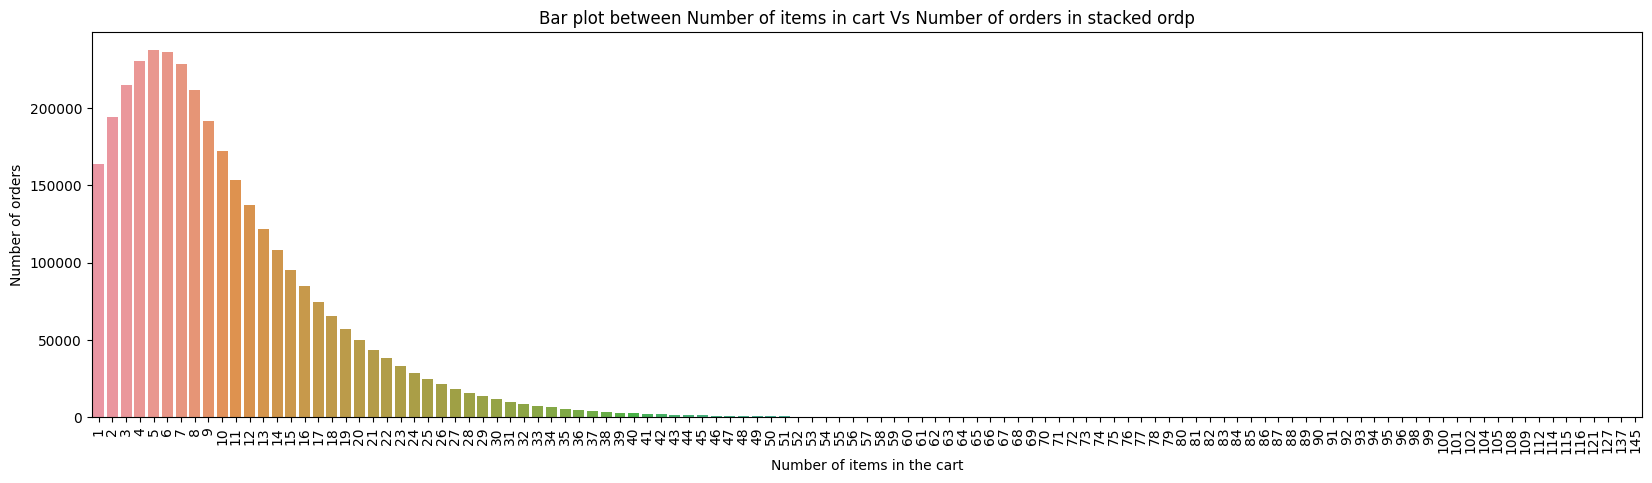

In [24]:
data = stacked_ordp.groupby("order_id")["add_to_cart_order"].count()
data = data.value_counts()
fig = plt.figure(figsize=(20,5))
sns.barplot(x = data.index, y= data.values)
plt.xlabel("Number of items in the cart")
plt.ylabel("Number of orders")
plt.title("Bar plot between Number of items in cart Vs Number of orders in stacked ordp")
plt.xticks(rotation = 90)
plt.show()

Observation:
* Most of orders have their cart filled in the range of 1 item to 20 items only.

### Bar plot between products with Reordered = 0  vs Reordered = 1

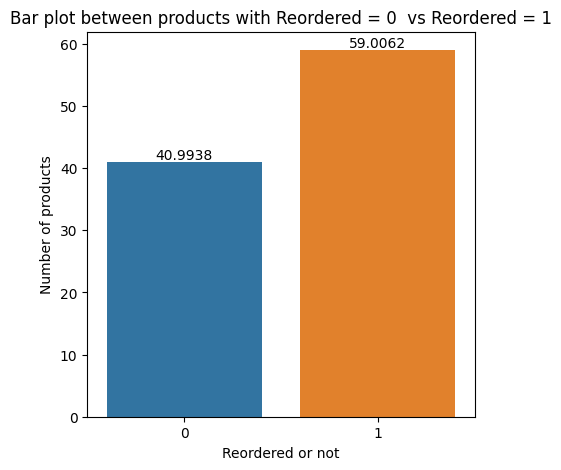

In [25]:
data = stacked_ordp["reordered"].value_counts()*100/stacked_ordp["product_id"].count()
fig = plt.figure(figsize=(5,5))
ax = sns.barplot(x = data.index, y= data.values)
ax.bar_label(ax.containers[0])
plt.xlabel("Reordered or not")
plt.ylabel("Number of products")
plt.title("Bar plot between products with Reordered = 0  vs Reordered = 1")
plt.show()

Observation:
* 40.99 % of products are bought only one time.

## Exploratory Data Analysis on Aisles, Products and Departments

### Joining Aisles, products and departments datasets

In [26]:
product_aisle = pd.merge(products,aisles,on = "aisle_id",how = "left")
product_aisle_dptms= pd.merge(product_aisle,dptms,on = "department_id",how = "left")

In [27]:
product_aisle_dptms.columns

Index(['product_id', 'product_name', 'aisle_id', 'department_id', 'aisle',
       'department'],
      dtype='object')

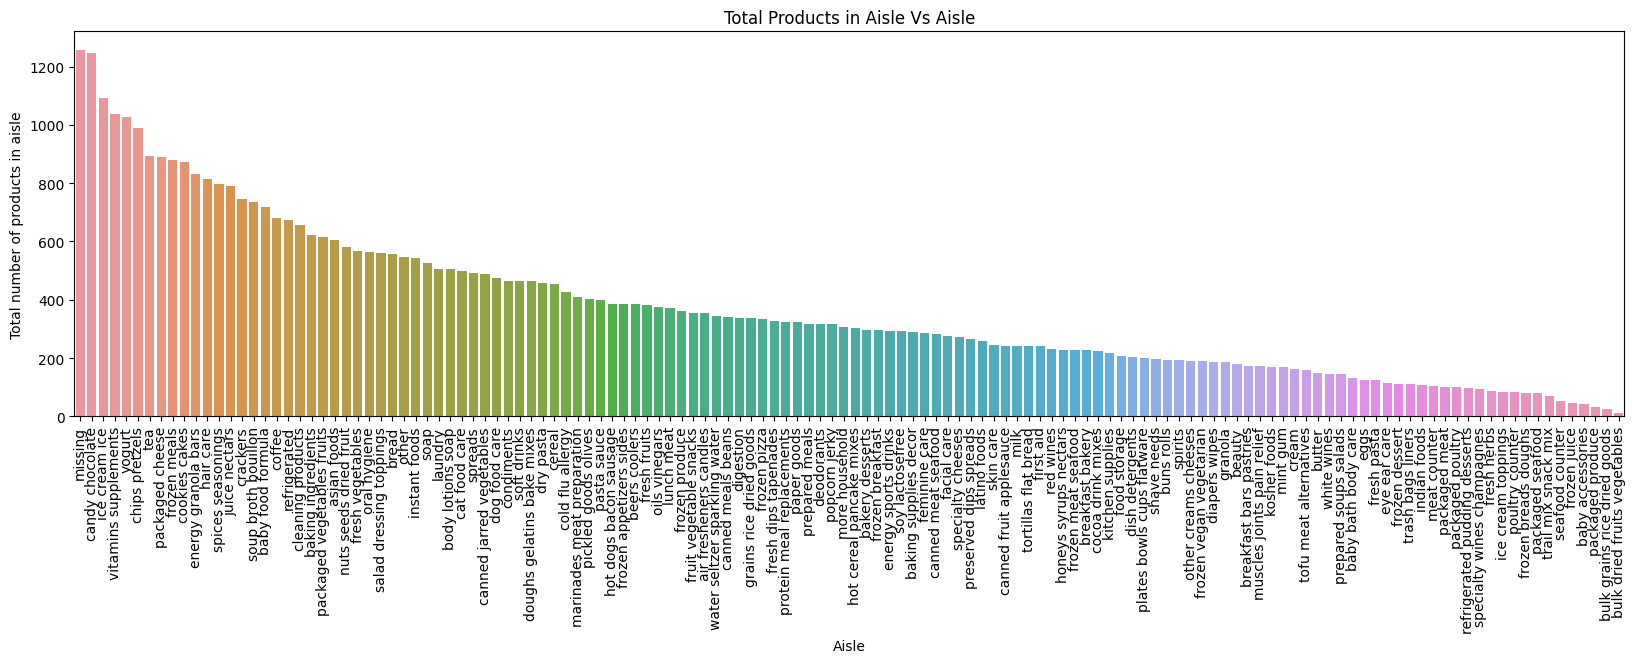

In [28]:
data = product_aisle_dptms.groupby("aisle")["product_id"].nunique().sort_values(ascending=False)
fig = plt.figure(figsize=(20,5))
sns.barplot(x = data.index, y = data.values)
plt.xlabel("Aisle")
plt.ylabel("Total number of products in aisle")
plt.title("Total Products in Aisle Vs Aisle")
plt.xticks(rotation = 90)
plt.show()

Observation:
* missing aisle, candy chocolate aisle and ice creams ice aisle are having more unique variety of products in them
* bulk dried fruits vegetables, bulk grains rice dried goods, packaged produce are have less unique variety of products in them

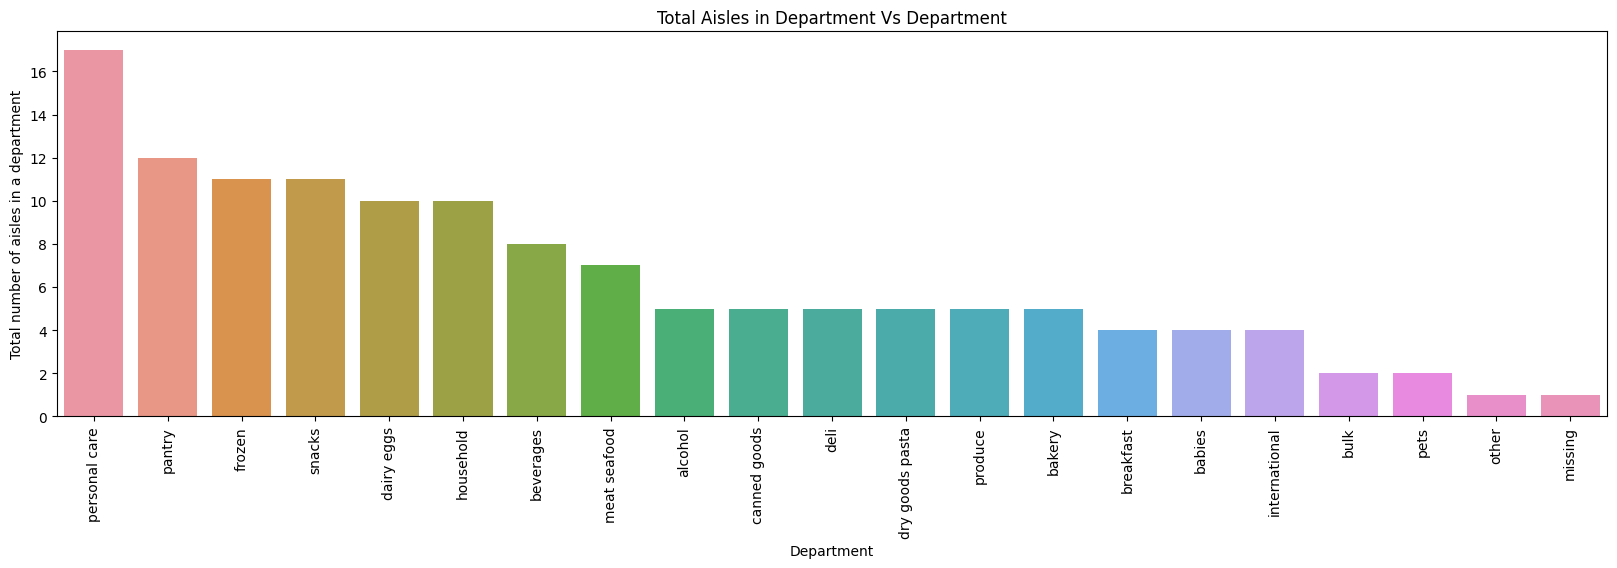

In [29]:
data = product_aisle_dptms.groupby("department")["aisle_id"].nunique().sort_values(ascending=False)
fig = plt.figure(figsize=(20,5))
sns.barplot(x = data.index, y = data.values)
plt.xlabel("Department")
plt.ylabel("Total number of aisles in a department")
plt.title("Total Aisles in Department Vs Department")
plt.xticks(rotation = 90)
plt.show()

Observation:
* personal care department has more number of aisles
* missing department has less number of aisles

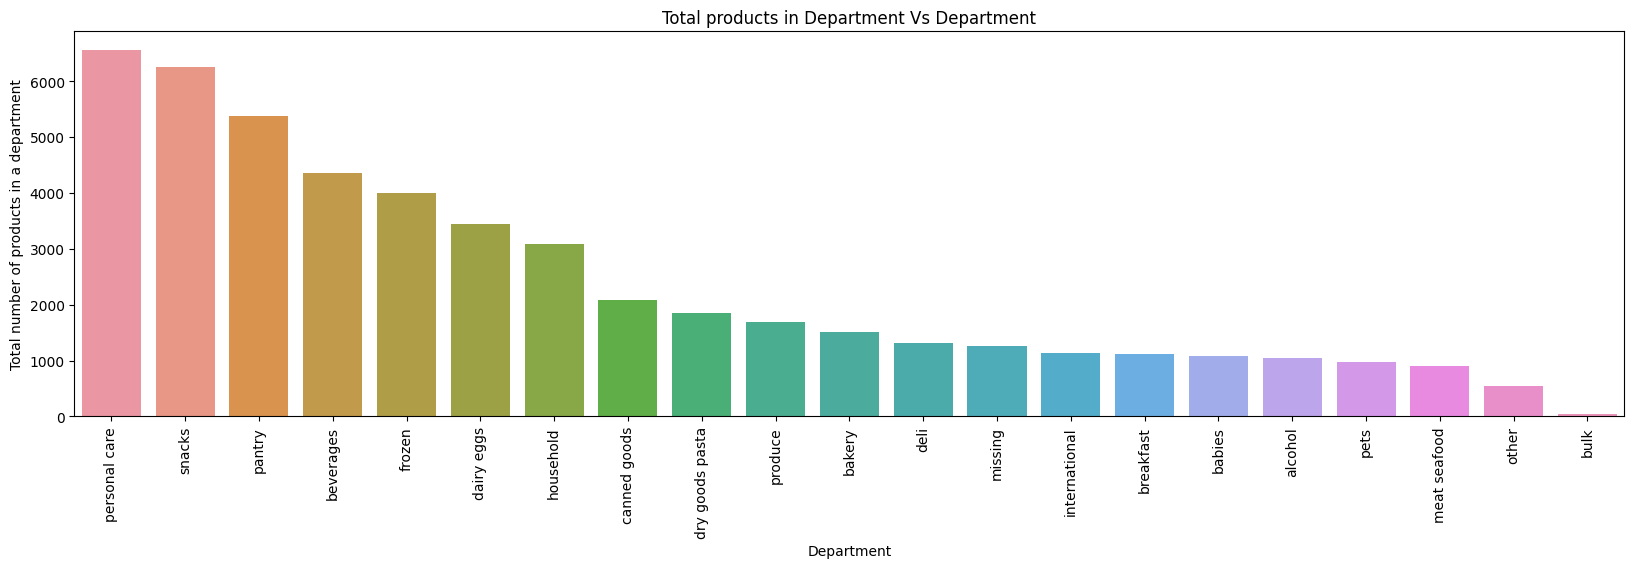

In [30]:
data = product_aisle_dptms.groupby("department")["product_id"].nunique().sort_values(ascending=False)
fig = plt.figure(figsize=(20,5))
sns.barplot(x = data.index, y = data.values)
plt.xlabel("Department")
plt.ylabel("Total number of products in a department")
plt.title("Total products in Department Vs Department")
plt.xticks(rotation = 90)
plt.show()

Observation:
* With respect to number of unique products, bulk department has less number of products. Personal care has more number of products

## Exploratory data analysis on merged_df

### Merge all the datasets

In [31]:
# Left Joining stacked_ordp with orders, products, departments and aisles
ordpp_orders = pd.merge(stacked_ordp,orders,on = "order_id",how = "left")
ordpp_orders_products = pd.merge(ordpp_orders,products,on = "product_id",how = "left")
ordpp_orders_products_departments = pd.merge(ordpp_orders_products,dptms,on = "department_id",how = "left")
merged_df = pd.merge(ordpp_orders_products_departments,aisles,on = "aisle_id",how = "left")


### Total number of product purchases from Aisle Vs Aisle

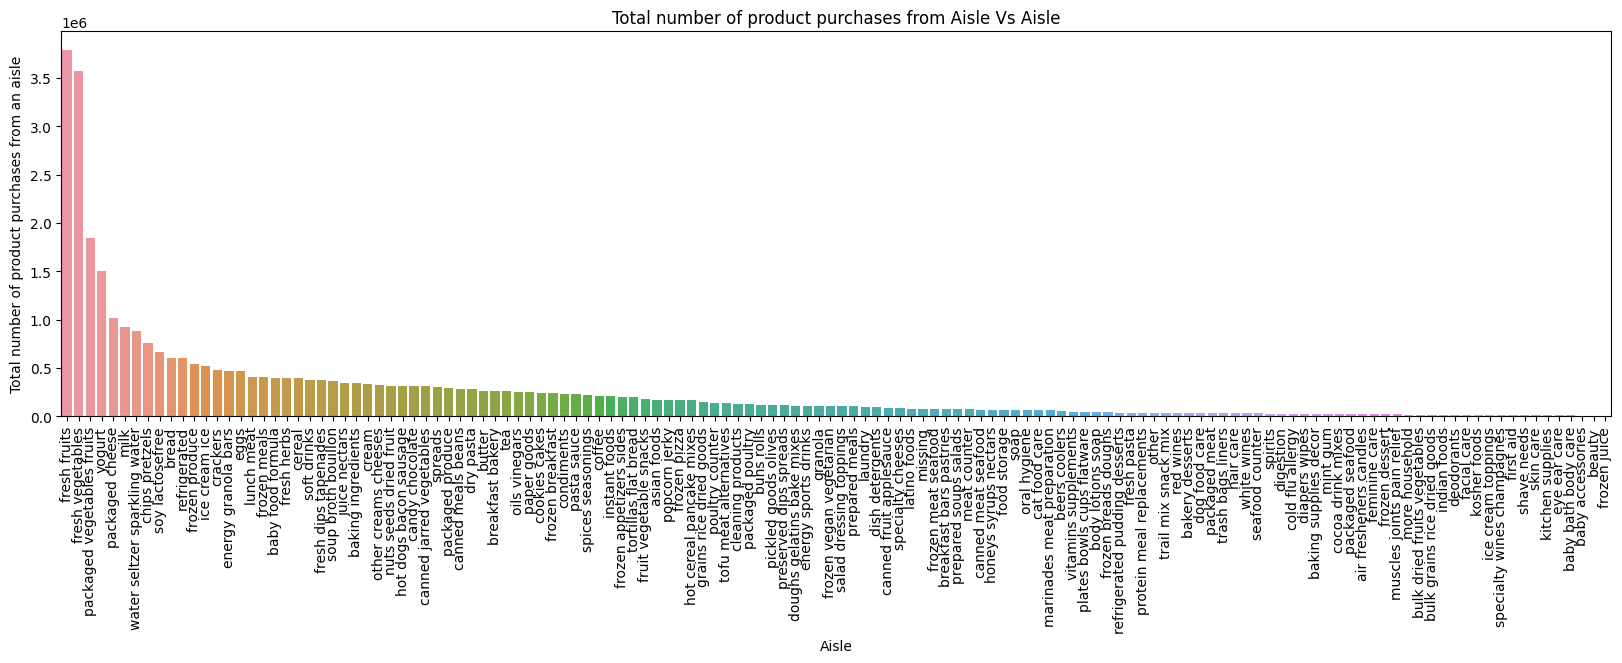

In [32]:
data = merged_df.groupby("aisle")["product_id"].count().sort_values(ascending=False)
fig = plt.figure(figsize=(20,5))
sns.barplot(x = data.index, y = data.values)
plt.xlabel("Aisle")
plt.ylabel("Total number of product purchases from an aisle")
plt.title("Total number of product purchases from Aisle Vs Aisle")
plt.xticks(rotation = 90)
plt.show()

Observation:
* fresh fruits, fresh vegetables, packaged vegetables fruits, yogurt, cheese, milk aisles highly dominates in terms of number of product purchases
* frojen juice, beauty, baby accessories, baby bath body cares, eye ear care are at bottom rank in terms of number of purchases

### Total number of product purchases from a Department Vs Department

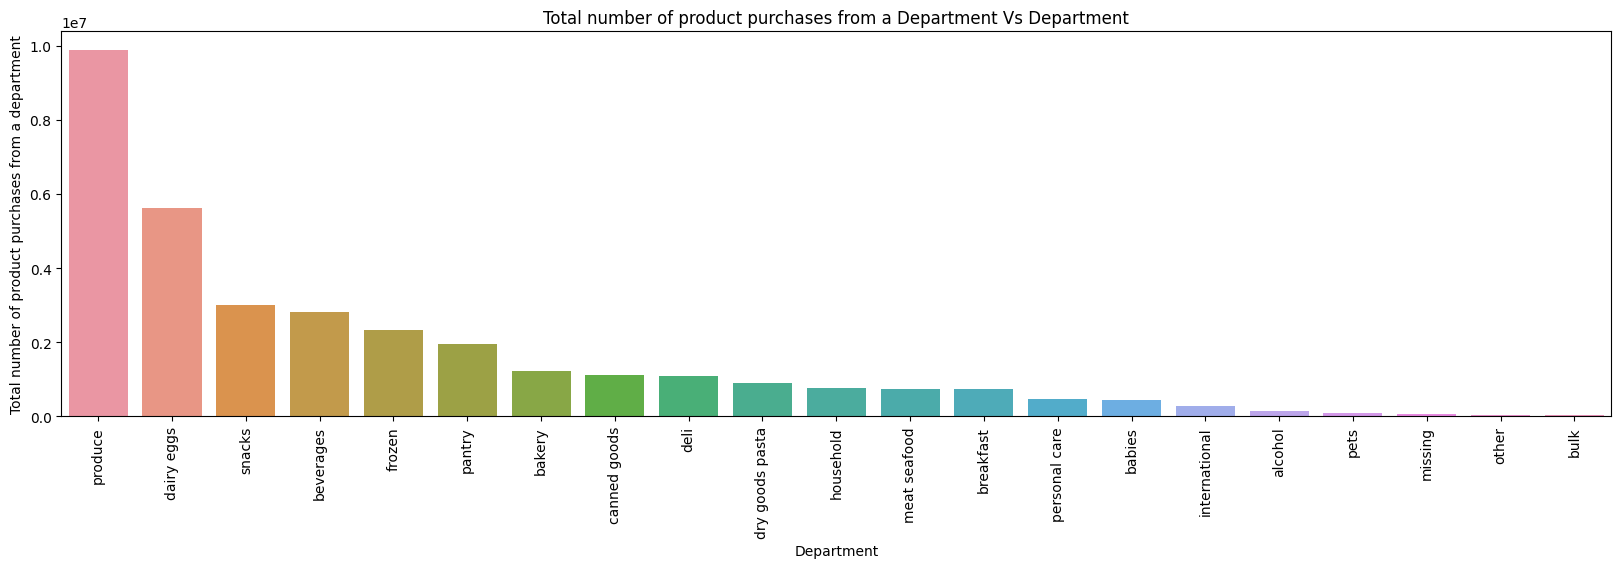

In [33]:
data = merged_df.groupby("department")["product_id"].count().sort_values(ascending=False)
fig = plt.figure(figsize=(20,5))
sns.barplot(x = data.index, y = data.values)
plt.xlabel("Department")
plt.ylabel("Total number of product purchases from a department")
plt.title("Total number of product purchases from a Department Vs Department")
plt.xticks(rotation = 90)
plt.show()

Observation:
* Even though personal care has more unique variety of products, It does not have more product purchases
* produce has less variety of products but having more number of product purchases

### Number of product purchases heat map between aisle and department 

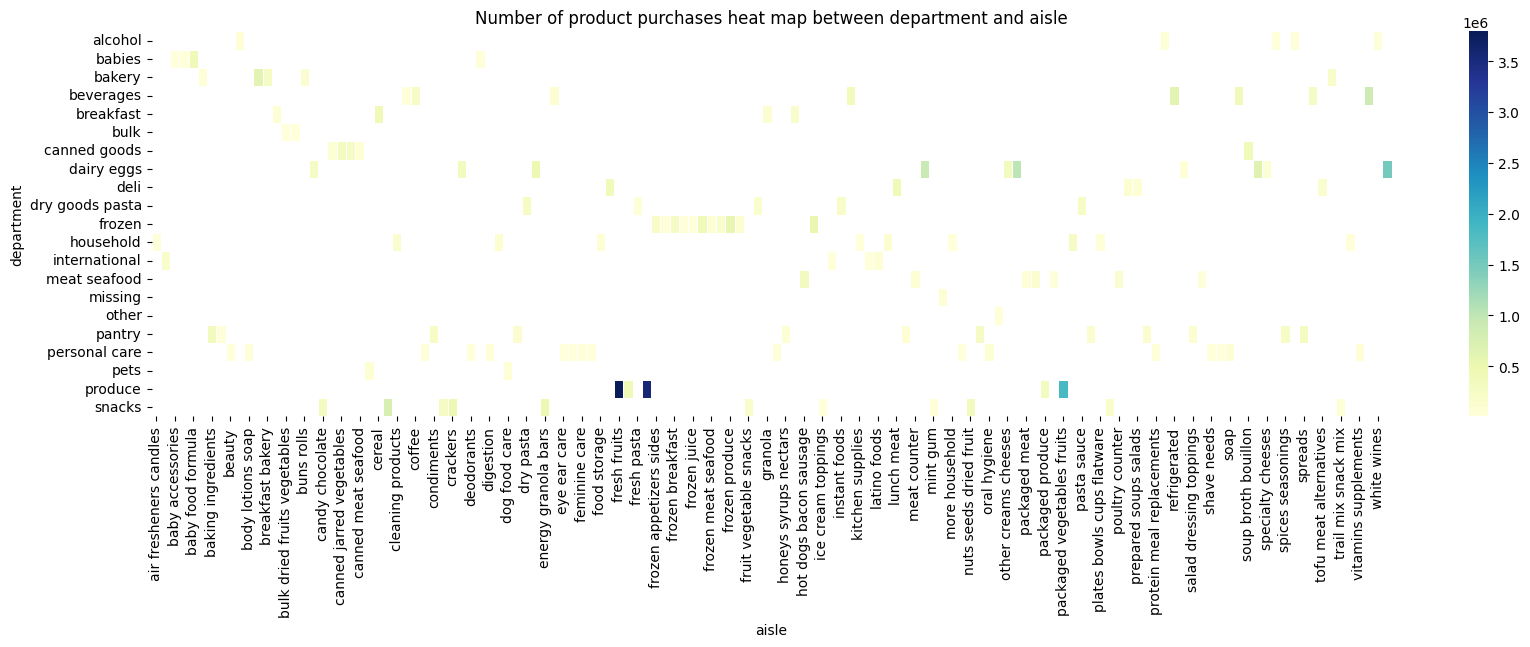

In [34]:
data = merged_df.groupby(["department","aisle"])["product_id"].count().reset_index()
data = data.pivot(index = "department",columns = "aisle",values = "product_id")
fig = plt.figure(figsize=(20,5))
sns.heatmap(data = data,cmap = "YlGnBu",linewidths=.5)
plt.title("Number of product purchases heat map between department and aisle")
plt.xlabel("aisle")
plt.ylabel("department")
plt.show()

Observation:
* Above heat map describing the predominant aisles regarding every department

### Reorder percentage For Each product

In [35]:
data = merged_df.groupby("product_name")["reordered"].agg(['count', 'sum']).rename(columns = {'count':'total','sum':'reorders'})
data = data.sort_values('total', ascending=False).reset_index()
data["product_reorder_percentage"] = data["reorders"]*100/data["total"]
data

,product_name,total,reorders,product_reorder_percentage
0,Banana,491291,415166,84.505110
1,Bag of Organic Bananas,394930,329275,83.375535
2,Organic Strawberries,275577,214448,77.817815
3,Organic Baby Spinach,251705,194939,77.447409
4,Organic Hass Avocado,220877,176173,79.760681
...,...,...,...,...
49680,Greek Blended Cherry Fat Free Yogurt,1,0,0.000000
49681,All Natural Stevia Liquid Extract Sweetener,1,0,0.000000
49682,"Frittata, Farmer's Market",1,0,0.000000
49683,Max White With Polishing Star Soft Toothbrush,1,0,0.000000


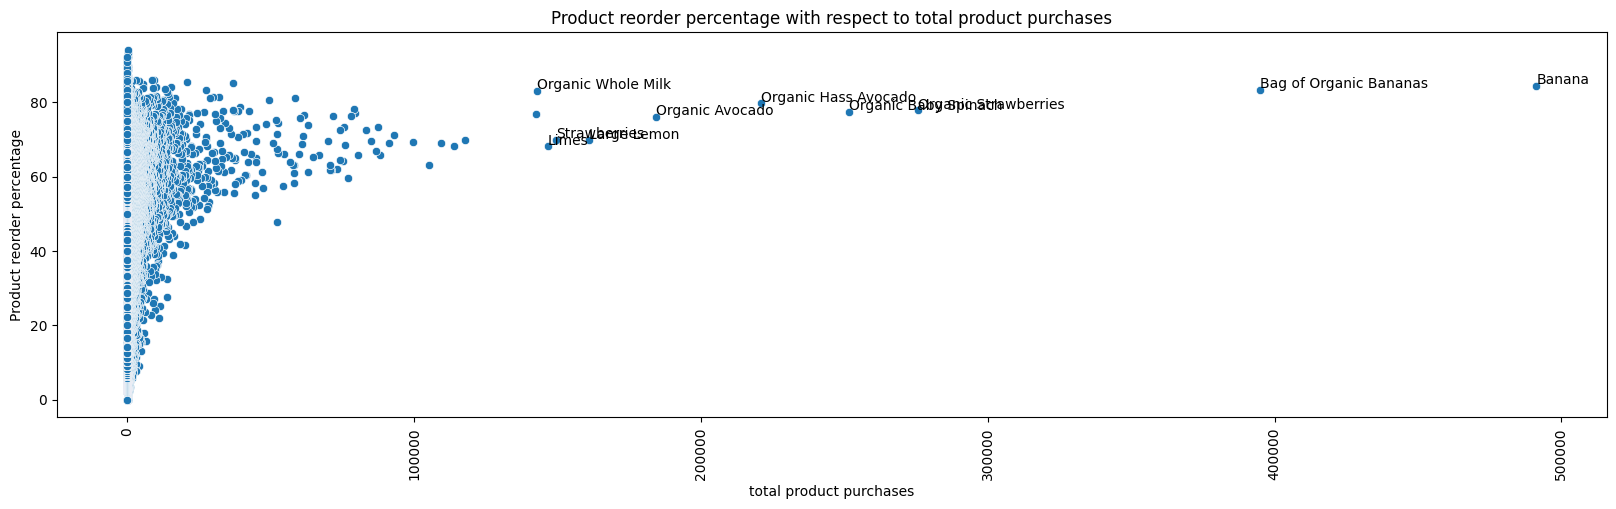

In [36]:
fig = plt.figure(figsize=(20,5))
sns.scatterplot(x = data["total"], y = data["product_reorder_percentage"])
plt.xlabel("total product purchases")
plt.ylabel("Product reorder percentage")
plt.title("Product reorder percentage with respect to total product purchases")
plt.xticks(rotation = 90)
for i in range(10):
    plt.annotate(data["product_name"][i],(data["total"][i],data["product_reorder_percentage"][i]+0.5),size = 10)
plt.show()

Observation:
* Top 10 purchased products are identified which are having higher reorder percentage and higher number of purchases

## Market Basket Analysis

Market Basket Analysis used by many retailers to find out the associations between the products based on data. It analyses combinations of items that purchases frequently in transactions. Association rules are formulated by using support and confidence metrics.

Support (Rule X → Y) = (frequency(X,Y))/total number of transactions<br><br>
Confidence(Rule X → Y) = (frequency(X,Y))/frequency(X)

Minimum threshold limits can be set to prune the products with lesser support and confidence. Transactions dataframe can be obtained from merged_df by grouping it by 'order_id' and stacking all the products per each order_id

In [37]:
# assumptions
min_support = 0.0001
min_confidence = 0.05
transactions = merged_df.groupby('order_id')['product_name'].apply(list)

In [38]:
transactions.head()

order_id
1    [Bulgarian Yogurt, Organic 4% Milk Fat Whole M...
2    [Organic Egg Whites, Michigan Organic Kale, Ga...
3    [Total 2% with Strawberry Lowfat Greek Straine...
4    [Plain Pre-Sliced Bagels, Honey/Lemon Cough Dr...
5    [Bag of Organic Bananas, Just Crisp, Parmesan,...
Name: product_name, dtype: object

Following functions helps to calculate the support and generate the frequent itemset based on transactions and minimum threshold values.

In [39]:
def calculate_support(transaction_series,r=1):
    counts = Counter()
    for transaction in transaction_series:
        counts.update(combinations(transaction, r))
    num_transactions = len(transaction_series)
    support = {item: count / num_transactions for item, count in counts.items()}
    return support

# Generate frequent itemsets
def generate_frequent_itemsets(transactions, min_support,r):
    support = calculate_support(transactions,r)
    frequent_itemsets = {itemset for itemset, count in support.items() if count >= min_support}
    return frequent_itemsets
frequent_itemsets = generate_frequent_itemsets(transactions, min_support,2)

* support1 is indicating the support values for each product in the transaction. 
* support2 is indicating the support values for product-combinations.

In [40]:
support1 = calculate_support(transactions,1)

In [41]:
support2 = calculate_support(transactions,2)

In [42]:
def generate_association_rules(frequent_itemsets, transactions, support1,support2,min_support,min_confidence):
    association_rules = []
    for itemset in frequent_itemsets:
        antecedent = itemset[0]
        consequent = itemset[1]
        rule_support = support2[itemset]
        rule_confidence = rule_support / support1[(antecedent,)]
        if rule_support >= min_support and rule_confidence >= min_confidence: 
            association_rules.append((antecedent, consequent, rule_support, rule_confidence))
    return association_rules
association_rules = generate_association_rules(frequent_itemsets, transactions,support1,support2,min_support, min_confidence)
association_rules_pd = pd.DataFrame(association_rules, columns = ["antecedent", "consequent", "support", "confidence"])
association_rules_pd = association_rules_pd.sort_values(["antecedent","confidence"],ascending= False)
associations = association_rules_pd.groupby(["antecedent"])["consequent"].apply(list).reset_index()

The following output provides the associations between products. For every antecedent, a list of consequent products are suggested. Final product associations can be visualised using networkx graph from pandas matplotlib.

In [43]:
associations

,antecedent,consequent
0,0% Fat Free Organic Milk,[Banana]
1,0% Greek Strained Yogurt,"[Clementines, Soda, Bag of Organic Bananas, Tr..."
2,1 Liter,[Organic Hass Avocado]
3,1% Low Fat Milk,"[Banana, Strawberries]"
4,1% Lowfat Milk,"[Banana, Organic Strawberries, Bag of Organic ..."
...,...,...
1351,Yukon Gold Potatoes 5lb Bag,"[Banana, Large Lemon, Organic Strawberries]"
1352,ZBar Organic Chocolate Brownie Energy Snack,"[Organic Strawberries, Banana, Kids Organic Ch..."
1353,Zen Tea,[Earl Grey Tea]
1354,Zero Calorie Cola,"[Soda, Clementines, Bag of Organic Bananas, Tr..."


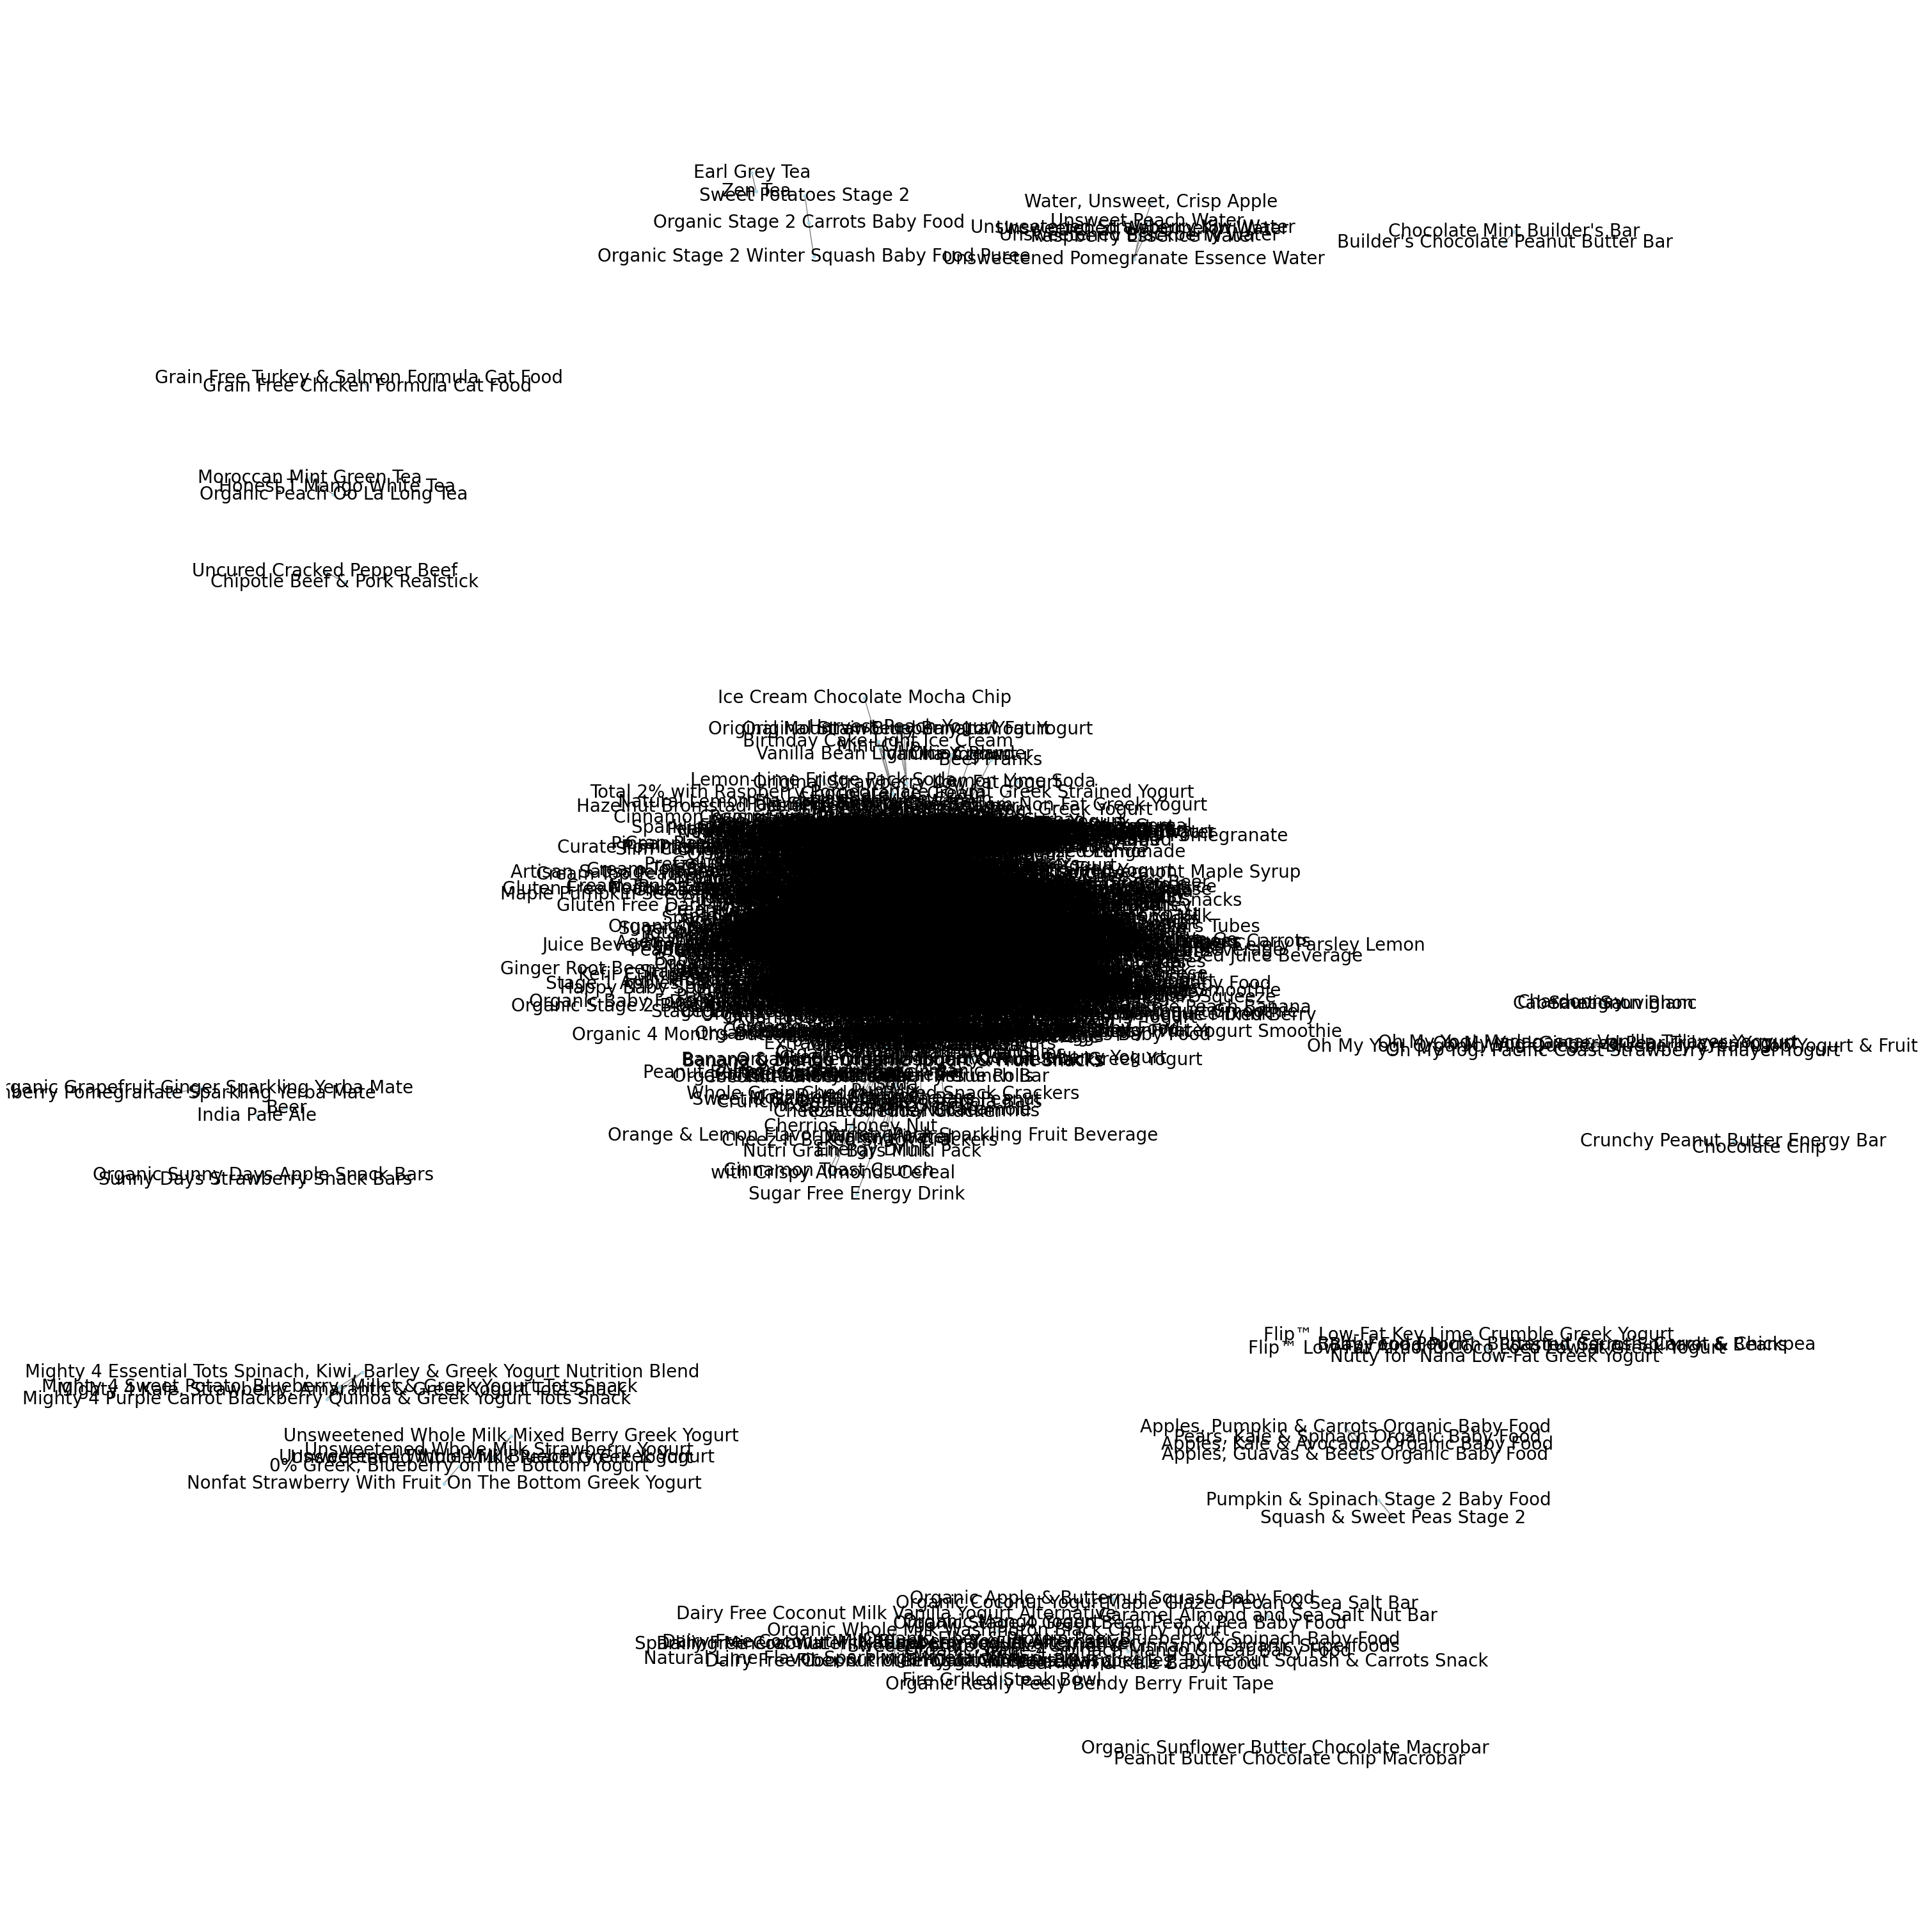

In [56]:
plt.figure(figsize=(30,30))
G = nx.Graph()
for _, row in associations.iterrows():
    antecedent = row['antecedent']
    consequent = row['consequent']
    for item in consequent:
        G.add_edge(antecedent, item.strip())
nx.draw(G, with_labels=True, node_color='lightblue', node_size=10, edge_color='gray',font_size = 20)
plt.show()

## Conclusion and Future scope:
1. Clusters can be observed in Network graph. These clusters are helpful in products suggestions. Large significant cluster in above graph represents that more number of products are interrelated to each other.
2. Market basket analysis uses support, confidence and lift to get product associations in Apriori Algorithm. Other types of similar algorithms such as FP-Growth algorithm, Eclat algorithm etc., also can be applied to find associations.
3. For large datasets, dask python module can help by multi-threading and parallel processing techniques.

## References:
1. https://www.scaler.com/topics/data-mining-tutorial/frequent-pattern-mining/
2. https://www.analyticsvidhya.com/blog/2021/10/a-comprehensive-guide-on-market-basket-analysis/
3. https://towardsdatascience.com/a-gentle-introduction-on-market-basket-analysis-association-rules-fa4b986a40ce
4. https://www.kaggle.com/competitions/instacart-market-basket-analysis/data